In [1]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')


In [2]:
#!pip install sktime
#!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

import pmdarima

from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.inspection import permutation_importance

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter

import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

%matplotlib inline
pd.options.mode.chained_assignment= None

# References:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### Loading Data

In [3]:
df_train_features = pd.read_csv('data/dengue_features_train.csv')
df_test_features = pd.read_csv('data/dengue_features_test.csv')
df_train_labels = pd.read_csv('data/dengue_labels_train.csv')

### Seperating data for SJ and IQ

In [4]:
df_train_features_sj = df_train_features.loc[df_train_features['city']=='sj',:].reset_index()
df_train_labels_sj = df_train_labels.loc[df_train_labels['city']=='sj',:].reset_index()
df_test_features_sj = df_test_features.loc[df_test_features['city']=='sj',:].reset_index()
print('San Juan:')
print('Total number of examples: ',df_train_features_sj.shape[0])
print('Total number of dengues cases: ',df_train_labels_sj['total_cases'].sum())
print('Total number of dengues cases per week on average: ',math.ceil(df_train_labels_sj['total_cases'].sum()/df_train_labels_sj.shape[0]))
print('Per year counts:\n')
display(pd.DataFrame([df_train_features_sj.rename(columns={'year':'no_of_weeks'})['no_of_weeks'].value_counts().sort_index(),df_train_labels_sj.groupby('year')['total_cases'].sum().sort_index()]))

print('Iquitos:')
df_train_features_iq = df_train_features.loc[df_train_features['city']=='iq',:].reset_index()
df_train_labels_iq = df_train_labels.loc[df_train_labels['city']=='iq',:].reset_index()
df_test_features_iq = df_test_features.loc[df_test_features['city']=='iq',:].reset_index()
print('\nTotal number of examples: ', df_train_features_iq.shape[0])
print('Total number of dengues cases: ',df_train_labels_iq['total_cases'].sum())
print('Total number of dengues cases per week on average: ',math.ceil(df_train_labels_iq['total_cases'].sum()/df_train_labels_iq.shape[0]))
print('Per year counts:\n')
display(pd.DataFrame([df_train_features_iq.rename(columns={'year':'no_of_weeks'})['no_of_weeks'].value_counts().sort_index(),df_train_labels_iq.groupby('year')['total_cases'].sum().sort_index()]))

San Juan:
Total number of examples:  936
Total number of dengues cases:  31993
Total number of dengues cases per week on average:  35
Per year counts:



,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
no_of_weeks,35,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,17
total_cases,866,2801,2371,1156,6533,1333,855,1454,4595,1633,492,1463,452,949,610,1805,550,1969,106


Iquitos:

Total number of examples:  520
Total number of dengues cases:  3934
Total number of dengues cases per week on average:  8
Per year counts:



,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
no_of_weeks,26,52,52,52,52,52,52,52,52,52,26
total_cases,4,14,704,114,638,311,436,365,801,324,223


### Distribution of dengue cases

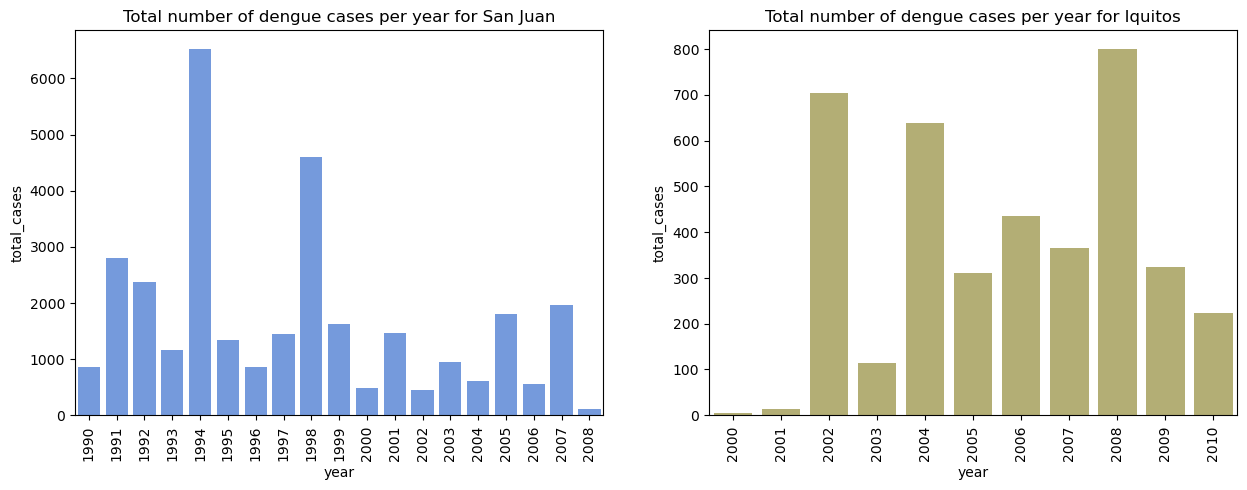

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
g1 = sns.barplot(data=df_train_labels_sj.groupby(['year'])['total_cases'].sum().reset_index(), x='year',y='total_cases',color = 'cornflowerblue',ax=axs[0])
g1.set_xticklabels(g1.get_xticklabels(),rotation=90);
g1.set_title('Total number of dengue cases per year for San Juan');
g2 = sns.barplot(data=df_train_labels_iq.groupby(['year'])['total_cases'].sum().reset_index(), x='year',y='total_cases',color = 'darkkhaki',ax=axs[1])
axs[1].set_title('Total number of dengue cases per year for Iquitos')
g2.set_xticklabels(g2.get_xticklabels(),rotation=90);

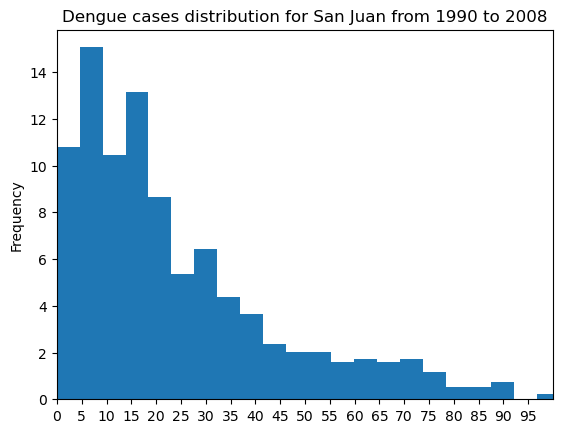

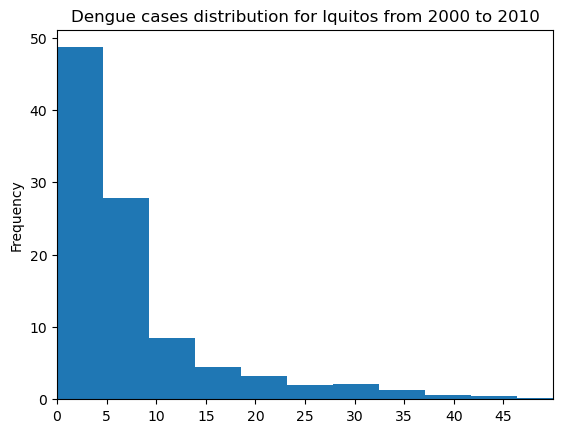

In [6]:
df = df_train_labels.loc[df_train_labels['city']=='sj','total_cases']
df.plot.hist(weights=100*np.ones_like(df)/len(df),bins=100)
plt.xlim((0,100))
plt.xticks(range(0,100,5));
plt.title('Dengue cases distribution for San Juan from 1990 to 2008');

plt.figure()
df = df_train_labels.loc[df_train_labels['city']=='iq','total_cases']
df.plot.hist(weights=100*np.ones_like(df)/len(df),bins=25)
plt.xlim((0,50))
plt.xticks(range(0,50,5));
plt.title('Dengue cases distribution for Iquitos from 2000 to 2010');

### Feature understanding

In [7]:
df_train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [8]:
print('Number of total columns:',len(df_train_features.columns),'\n')
print(list(df_train_features.columns),'\n')
print('Number of useable features:', len(df_train_features.drop(['city', 'year', 'weekofyear', 'week_start_date'],axis=1).columns),'\n')
print('Info for iq = Iquitos and sj = San Juan:')
display(pd.DataFrame({
    'no. of observations (train)': df_train_features.groupby('city').size(),
    'from (train)': df_train_features.groupby('city')['year'].min(),
    'to (train)': df_train_features.groupby('city')['year'].max(),
    'no. of years (train)':df_train_features.groupby('city')['year'].nunique(),
    'no. of observations (test)': df_test_features.groupby('city').size(),
    'from (test)': df_test_features.groupby('city')['year'].min(),
    'to (test)': df_test_features.groupby('city')['year'].max(),
    'no. of years (test)':df_test_features.groupby('city')['year'].nunique(),
    'no. of dengues cases':df_train_labels.groupby('city')['total_cases'].sum(),
    'avg no. of dengues cases per week':df_train_labels.groupby('city')['total_cases'].mean()}))

Number of total columns: 24 

['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm'] 

Number of useable features: 20 

Info for iq = Iquitos and sj = San Juan:


,no. of observations (train),from (train),to (train),no. of years (train),no. of observations (test),from (test),to (test),no. of years (test),no. of dengues cases,avg no. of dengues cases per week
city,,,,,,,,,,
iq,520,2000,2010,11,156,2010,2013,4,3934,7.565385
sj,936,1990,2008,19,260,2008,2013,6,31993,34.180556


In [9]:
useable_features = list(df_train_features.drop(['city','weekofyear','week_start_date','year'],axis=1).columns)

### Feature Description

In [10]:
ndvi = [x for x in list(df_train_features.columns) if 'ndvi' in x] 
reanalysis = [x for x in list(df_train_features.columns) if 'reanalysis' in x]
precip = [x for x in list(df_train_features.columns) if 'precipitation' in x]
station = [x for x in list(df_train_features.columns) if 'station' in x]
all_features = [ndvi,reanalysis,precip,station]
max_len = max([len(i) for i in all_features])
for i in range(len(all_features)):
    if len(all_features) < max_len:
        all_features[i] += [''] * (max_len - len(all_features[i]))

display(pd.DataFrame({
    'CDR Normalized Difference Vegetation Index':all_features[0],
    'NCEP Climate Forecast System Reanalysis':all_features[1],
    'CDR PERSIANN Precipitation Product':all_features[2],
    'GHCN daily climate data':all_features[3]}))

,CDR Normalized Difference Vegetation Index,NCEP Climate Forecast System Reanalysis,CDR PERSIANN Precipitation Product,GHCN daily climate data
0,ndvi_ne,reanalysis_air_temp_k,precipitation_amt_mm,station_avg_temp_c
1,ndvi_nw,reanalysis_avg_temp_k,,station_diur_temp_rng_c
2,ndvi_se,reanalysis_dew_point_temp_k,,station_max_temp_c
3,ndvi_sw,reanalysis_max_air_temp_k,,station_min_temp_c
4,,reanalysis_min_air_temp_k,,station_precip_mm
5,,reanalysis_precip_amt_kg_per_m2,,
6,,reanalysis_relative_humidity_percent,,
7,,reanalysis_sat_precip_amt_mm,,
8,,reanalysis_specific_humidity_g_per_kg,,
9,,reanalysis_tdtr_k,,


### Distribution of Features

#### Vegetation

In [11]:
def plot_distributions(ls,w,h,ft,r,c,feature,sharey=False):
    l = [x for x in ls if x != '']
    fig,axs = plt.subplots(nrows=r, ncols=c,figsize=(w,h),sharey=sharey)
    if hasattr(axs, "__len__"):
        axs = axs.flatten()
        for i,a in zip(l,axs):
            sns.boxplot(data=df_train_features, y=i, x="city",ax=a)
    else:
        for i in l:
            sns.boxplot(data=df_train_features, y=i, x="city",ax=axs)
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Distribution of '+ feature +' features for both San Juan and Iquitos', fontsize = ft)

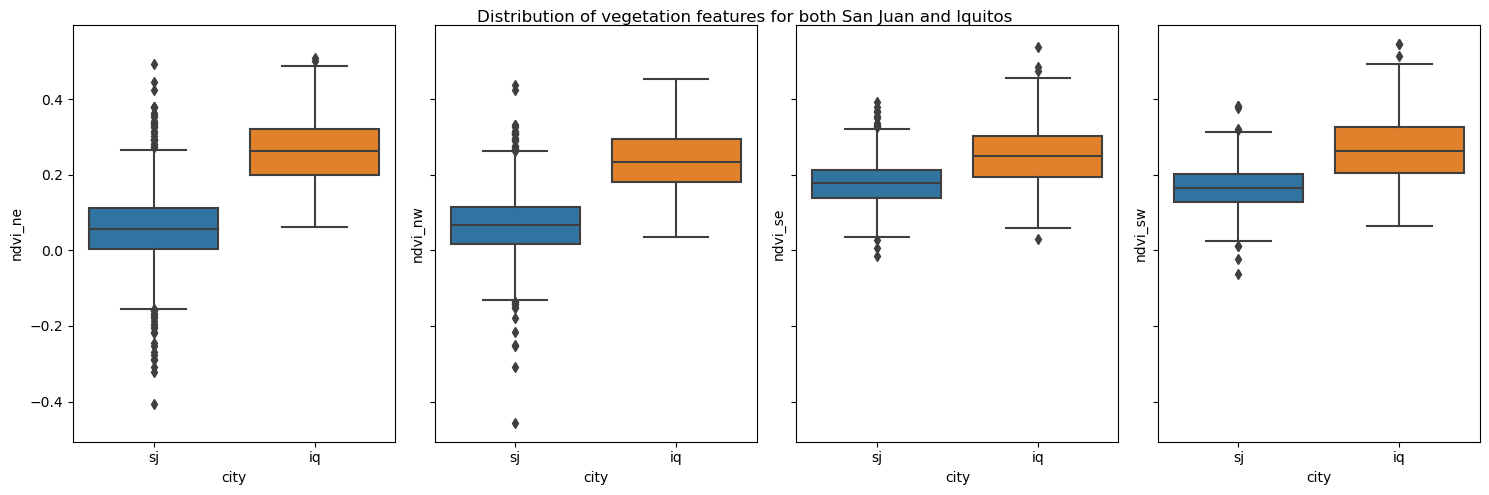

In [12]:
plot_distributions(ndvi,15,5,12,1,4,'vegetation',True)

There seems to be more vegetation in Iquitos compared to San Juan. Iquitos also seems to have fewer water bodies (cases where ndvi < 0). There are outlier areas in ndvi where there is more vegetation. 

In [13]:
sj_correlations = pd.concat([df_train_features_sj.loc[:,useable_features],df_train_labels_sj.loc[:,'total_cases']],axis=1).corr()
iq_correlations = pd.concat([df_train_features_iq.loc[:,useable_features],df_train_labels_iq.loc[:,'total_cases']],axis=1).corr()

In [14]:
def corr_heatmap(var,var_list,w=25,h=10):
    fig, axs = plt.subplots(1,2, figsize=(w,h))
    for i,j,k in zip(range(2),[sj_correlations,iq_correlations],['San Juan','Iquitos']):
        sns.heatmap(j.reset_index().loc[(j.reset_index()['index'].str.contains(var)|j.reset_index()['index'].str.contains("total_cases")),
                                                  [x for x in var_list if x != '']+['index']+['total_cases']].set_index('index'),
               cmap="crest",annot=True,ax=axs[i]);
    
        axs[i].title.set_text(k);
    fig.tight_layout()
    sns.set(style="whitegrid", font_scale=2.5)


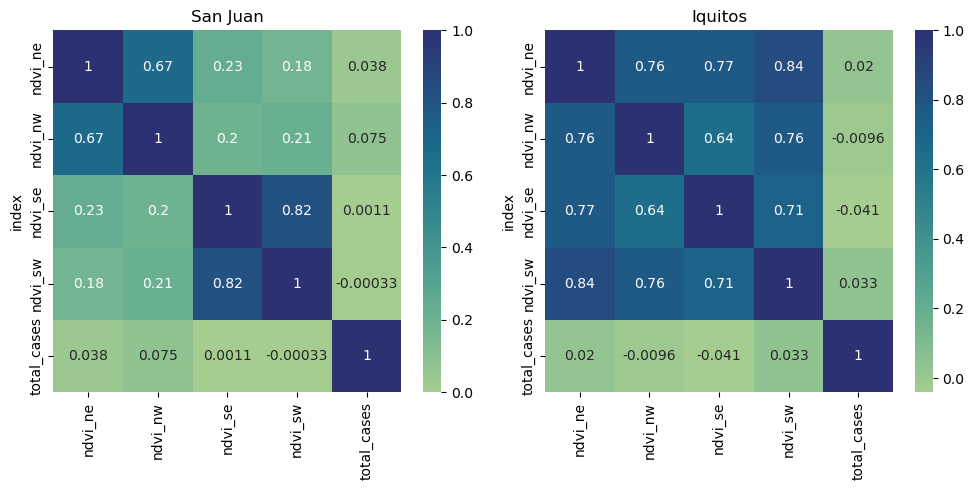

In [15]:
corr_heatmap('ndvi',ndvi,10,5)
matplotlib.rc_file_defaults()

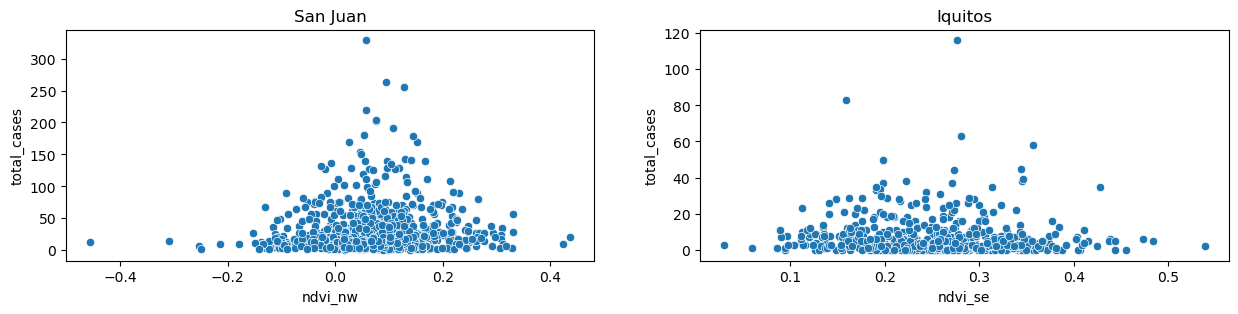

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
sns.scatterplot(x="ndvi_nw", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="ndvi_se", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Reanalysis 

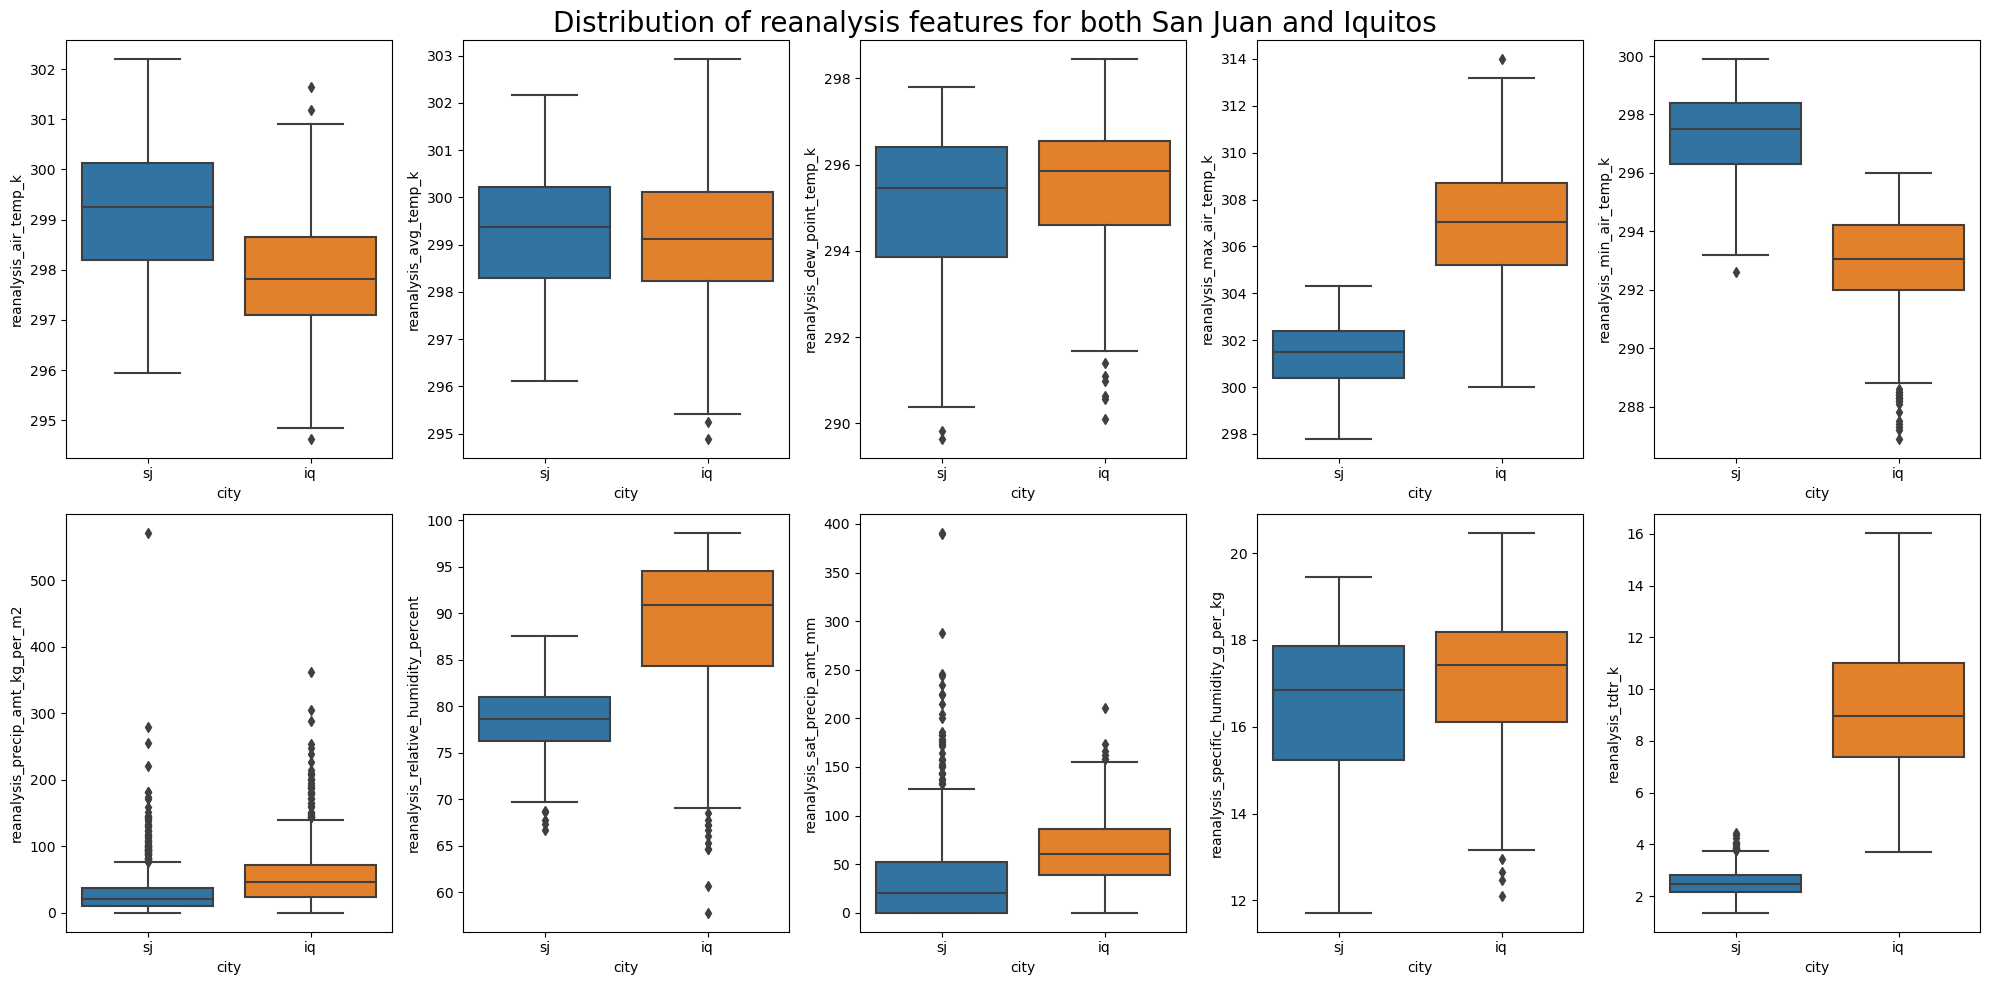

In [17]:
plot_distributions(reanalysis,20,10,20,2,5,'reanalysis')

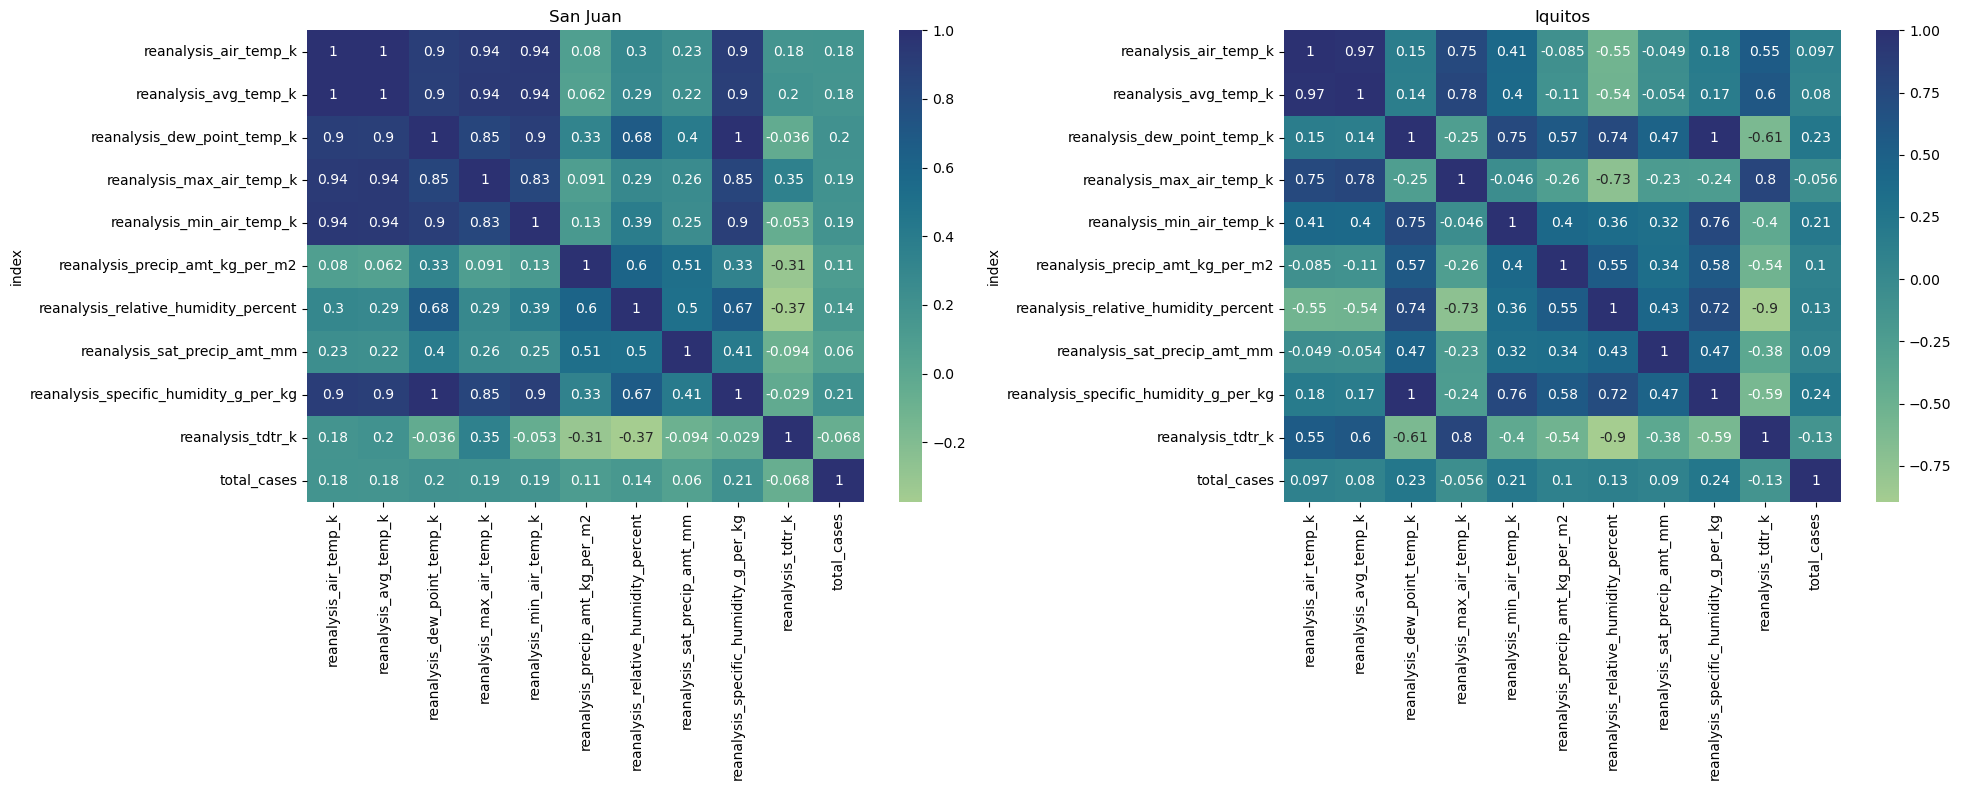

In [18]:
var = 'reanalysis'
var_list = reanalysis
corr_heatmap('reanalysis',reanalysis,20,8)
matplotlib.rc_file_defaults()

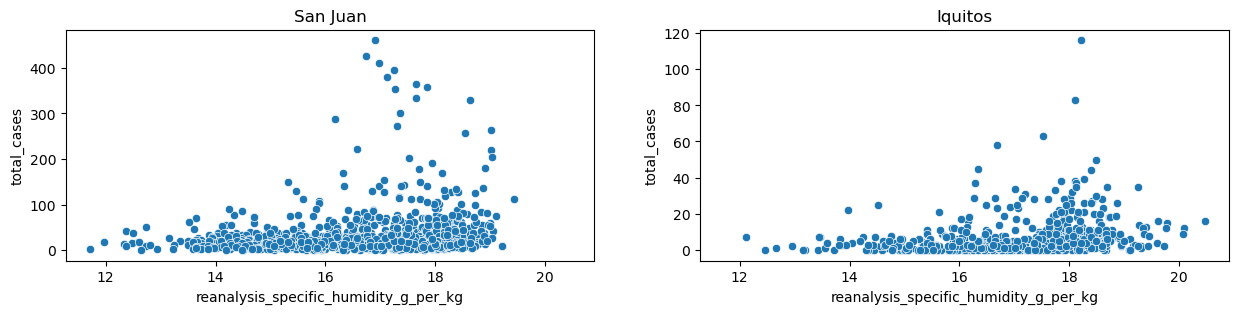

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Precipitation

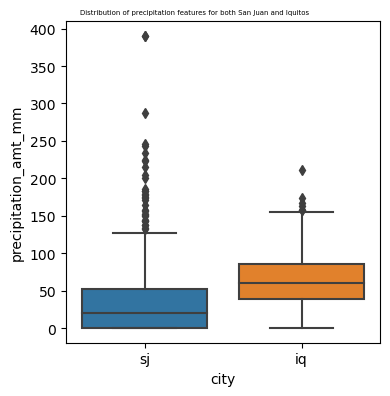

In [20]:
plot_distributions(precip,4,4,5,1,1,'precipitation')

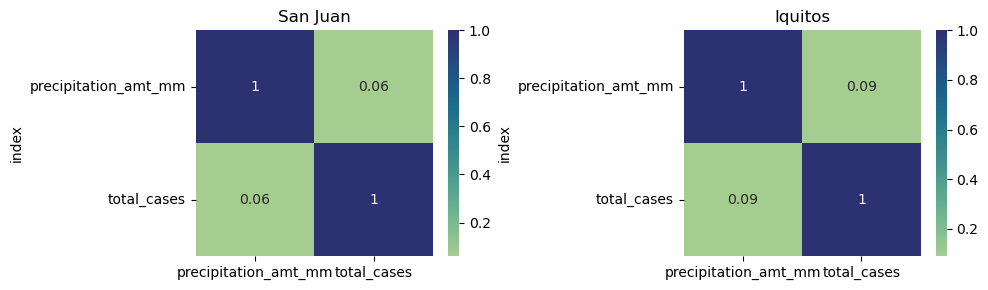

In [21]:
corr_heatmap('precipitation',precip,10,3)
matplotlib.rc_file_defaults()

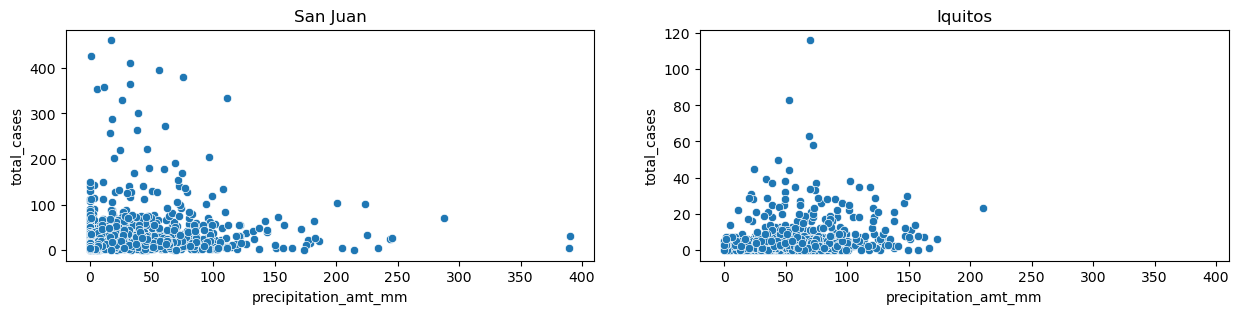

In [22]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="precipitation_amt_mm", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="precipitation_amt_mm", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Climate

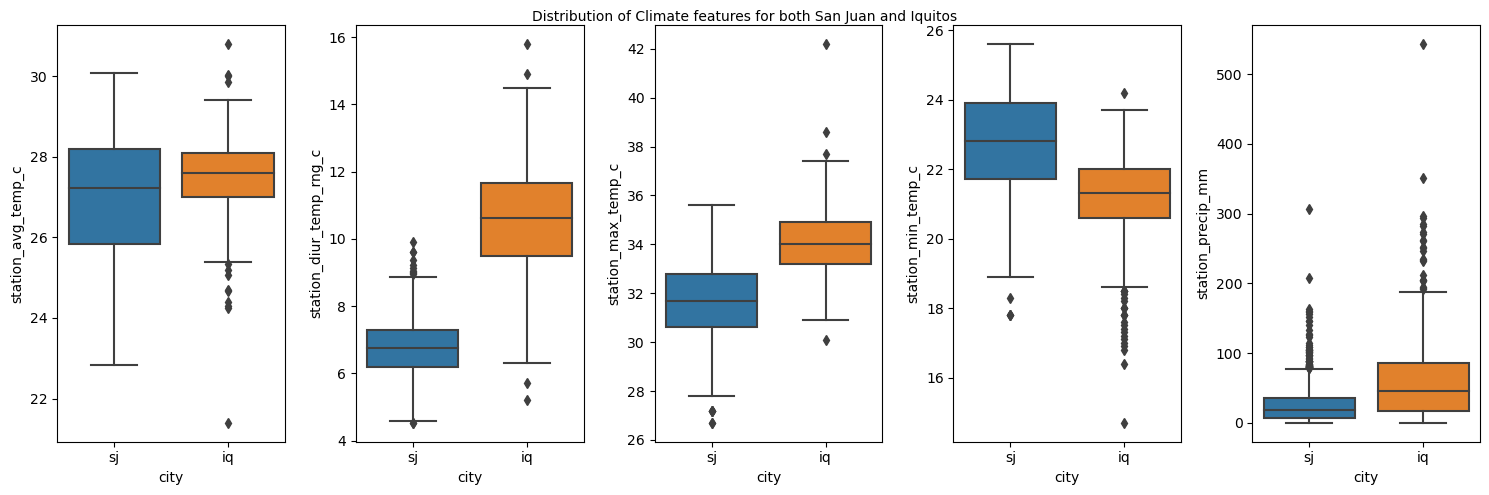

In [23]:
plot_distributions(station,15,5,10,1,5,'Climate')

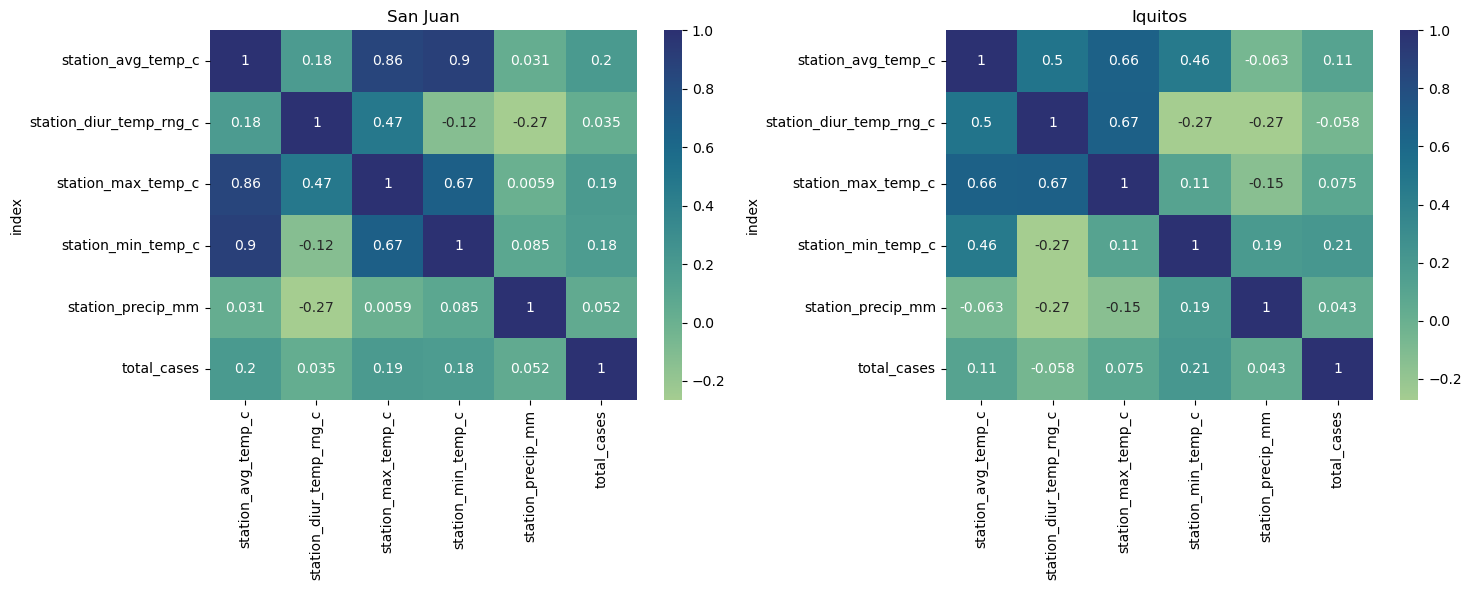

In [24]:
corr_heatmap('station',station,15,6)
matplotlib.rc_file_defaults()

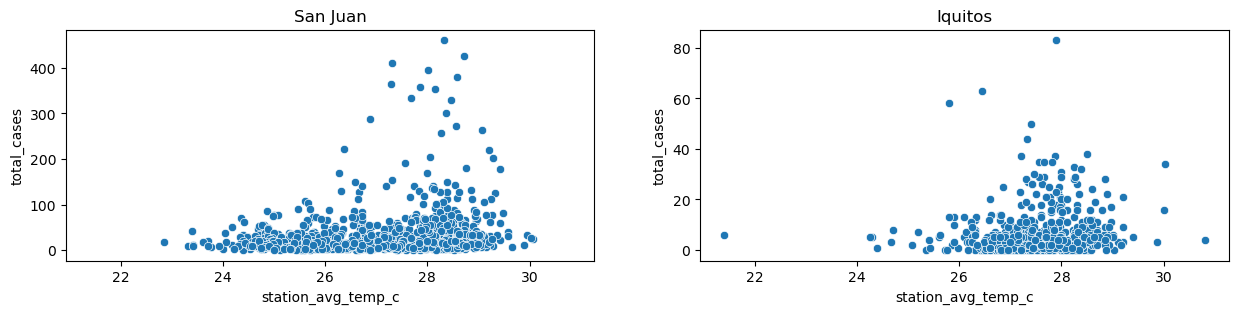

In [25]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

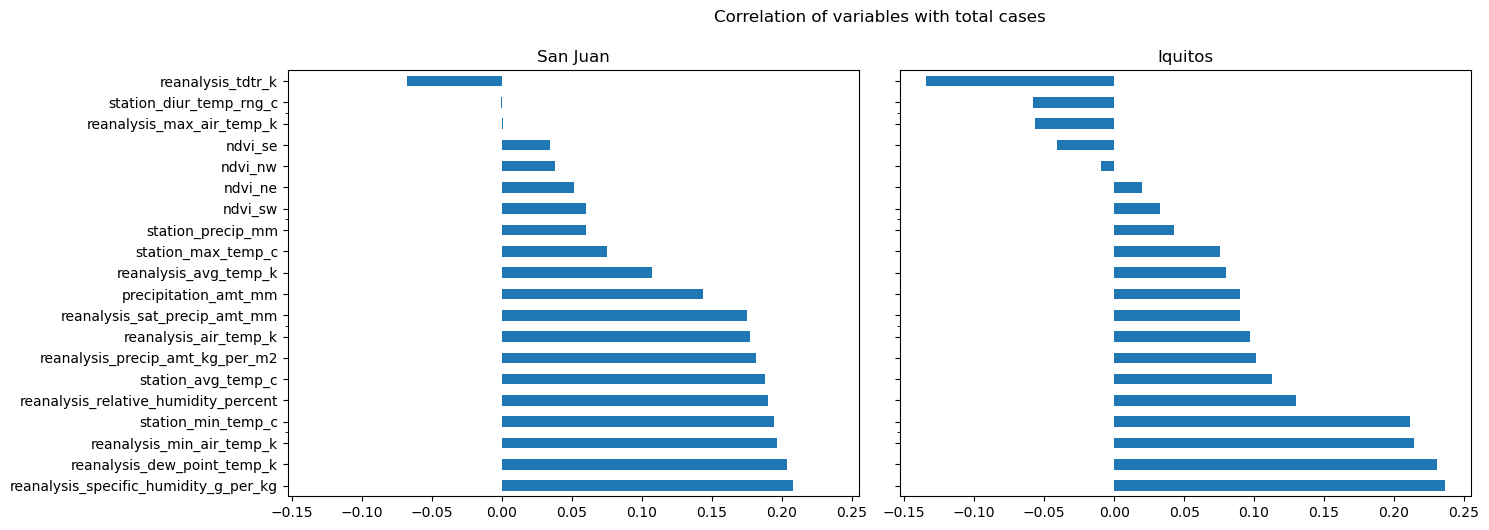

In [26]:
# reference: https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb
fig, axs = plt.subplots(1,2, figsize=(15,5),sharey=True,sharex=True)
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(ax=axs[0]))
axs[0].title.set_text('San Juan');
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(ax=axs[1]))
axs[1].title.set_text('Iquitos');
fig.tight_layout();
fig.suptitle('Correlation of variables with total cases',x=0.59,y=1.05);

### Sanity Checks

In [27]:
### there are no unique values set as a placeholder for missing values e.g. -9999
display(df_train_features['precipitation_amt_mm'].value_counts(1).sort_index(ascending=False).reset_index().loc[0:2,])
display(df_train_features['station_precip_mm'].value_counts(1).sort_index(ascending=False).reset_index().loc[0:2,])

,index,precipitation_amt_mm
0,390.60,0.000693
1,389.60,0.000693
2,287.55,0.000693


,index,station_precip_mm
0,543.3,0.000697
1,350.9,0.000697
2,305.9,0.000697


In [28]:
## See if there are longer than 9 days of gaps in the data (making sure that we have weekly data)
dg = df_train_features.copy()
dg['diff'] = pd.to_datetime(df_train_features['week_start_date']).diff().dt.days
dg.loc[dg['diff']>9,['city', 'year','week_start_date','diff']]

,city,year,week_start_date,diff


In [29]:
print('San Juan')
#any year with 0 cases?
display(pd.DataFrame(df_train_labels_sj.groupby('year')['total_cases'].sum()).transpose())
#check for the year that has lowest number of cases. How many weeks of data do we have for that year
display(df_train_labels_sj.loc[df_train_labels_sj['year']==2008,['year','weekofyear','total_cases']].reset_index(drop=True).transpose());

San Juan


year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
total_cases,866,2801,2371,1156,6533,1333,855,1454,4595,1633,492,1463,452,949,610,1805,550,1969,106


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
year,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008
weekofyear,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
total_cases,15,14,15,10,9,2,6,8,5,1,2,3,4,3,1,3,5


In [30]:
print('Iquitos')
#any year with 0 cases?
display(pd.DataFrame(df_train_labels_iq.groupby('year')['total_cases'].sum()).transpose())
#check for the year that has lowest number of cases. How many weeks of data do we have for that year
display(df_train_labels_iq.loc[df_train_labels_iq['year']==2000,['year','weekofyear','total_cases']].reset_index(drop=True).transpose());

Iquitos


year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
total_cases,4,14,704,114,638,311,436,365,801,324,223


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
year,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
weekofyear,26,27,28,29,30,31,32,33,34,35,...,42,43,44,45,46,47,48,49,50,51
total_cases,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [31]:
percent_missing_sj = 100*df_train_features_sj.isnull().sum()/len(df_train_features_sj)
percent_missing_iq = 100*df_train_features_iq.isnull().sum()/len(df_train_features_iq)
df_missing_stats = pd.DataFrame({'precent_missing_sj' : percent_missing_sj, 
                                 'precent_missing_iq' : percent_missing_iq})
df_missing_stats.transpose()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
precent_missing_sj,0.0,0.0,0.0,0.0,0.0,20.405983,5.235043,2.029915,2.029915,0.961538,...,0.641026,0.641026,0.961538,0.641026,0.641026,0.641026,0.641026,0.641026,0.641026,0.641026
precent_missing_iq,0.0,0.0,0.0,0.0,0.0,0.576923,0.576923,0.576923,0.576923,0.769231,...,0.769231,0.769231,0.769231,0.769231,0.769231,7.115385,7.115385,2.692308,1.538462,3.076923


#### Year on year plot for ndvi_ne for San Juan

ndvi_ne is mostly missing for San Juan in year 1994 after 35th week

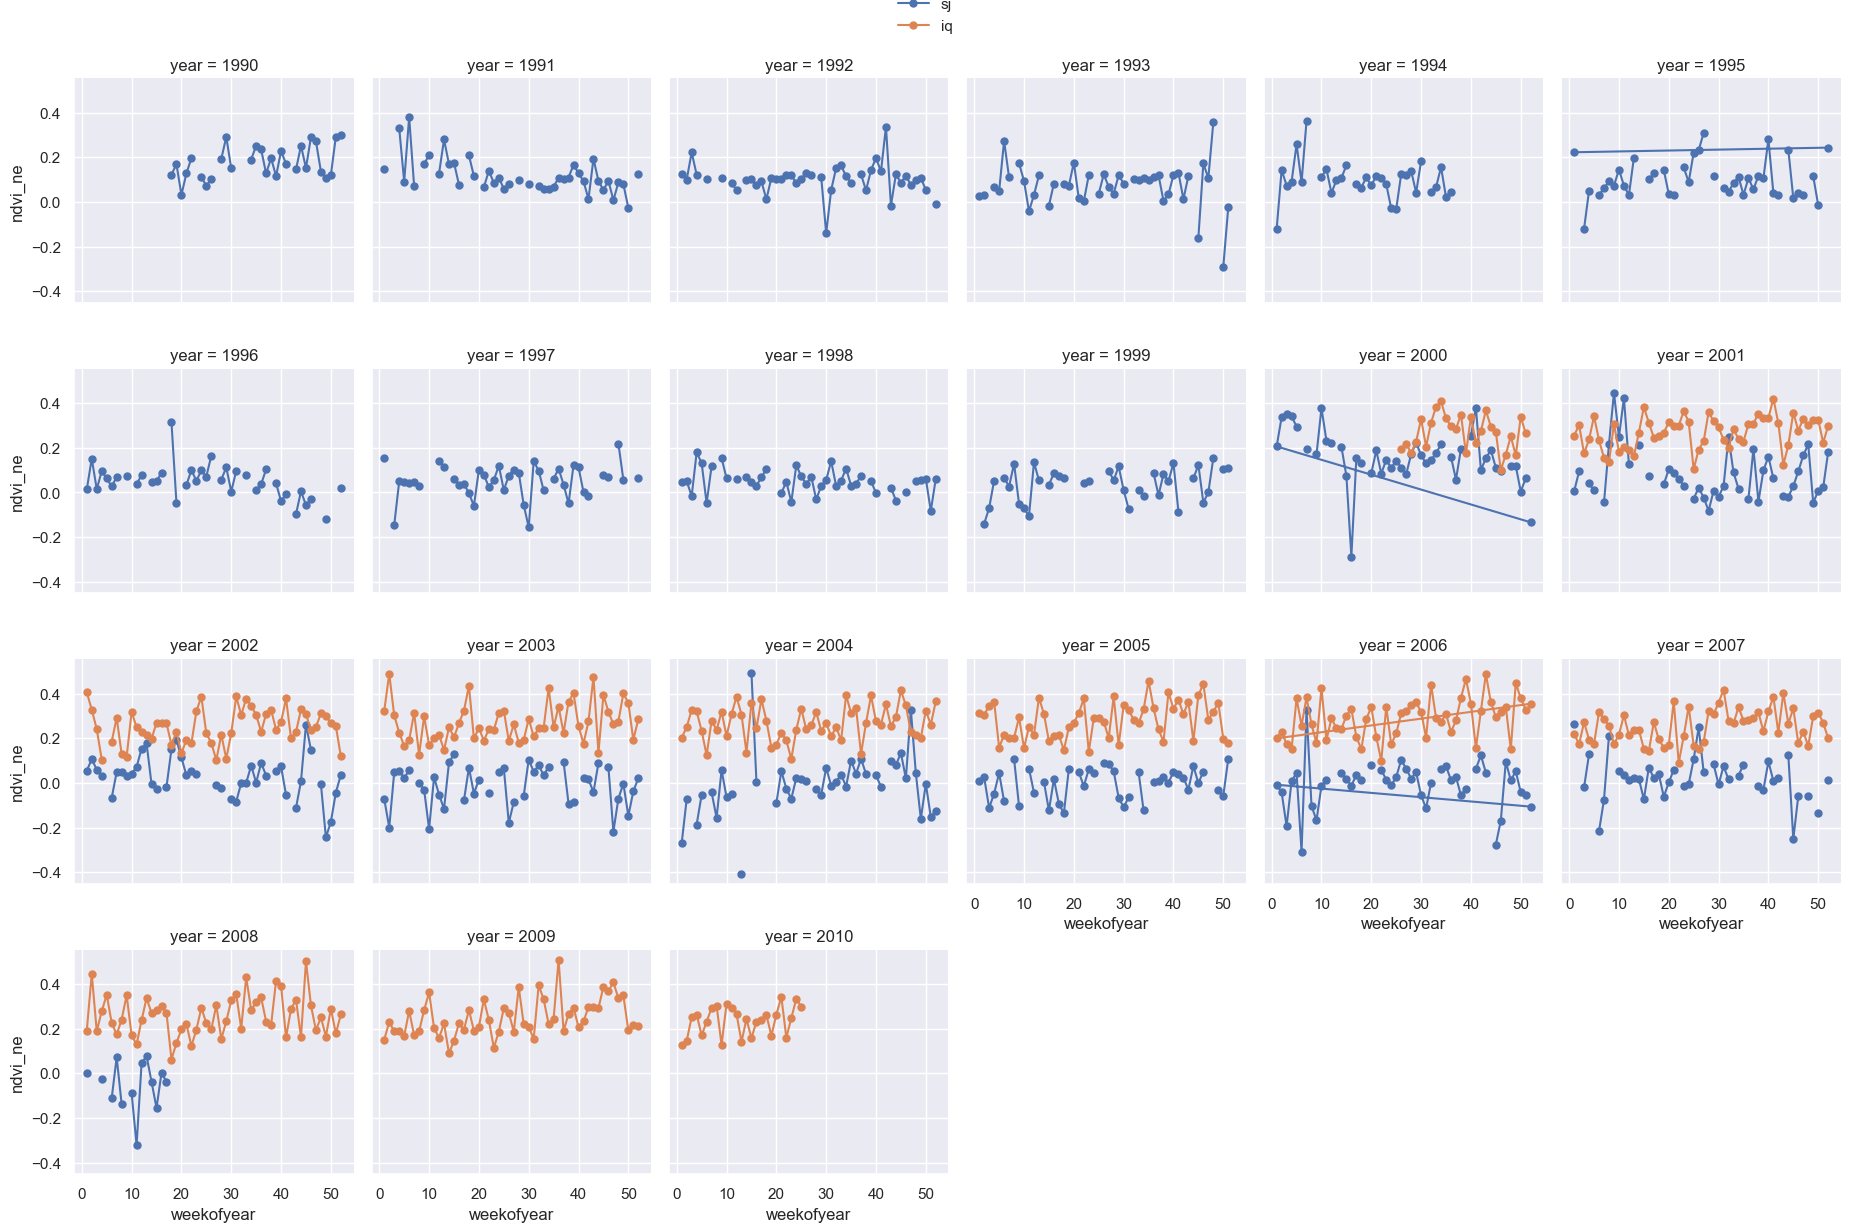

In [32]:
sns.set(rc={'figure.figsize':(20,35)})
graph = sns.FacetGrid(df_train_features,col='year', hue='city', col_wrap=6)
graph.map_dataframe(plt.plot,'weekofyear','ndvi_ne', marker = '.', markersize = 10).add_legend(loc='upper center',borderaxespad=-2)
plt.tight_layout()
plt.show()

ndvi_ne has 20% missing values for SJ so we will look at that. From the graph we see that year 1994 is missing after 35th week

Text(0.5, 1.0, 'ndvi_ne for San Juan for year 1994')

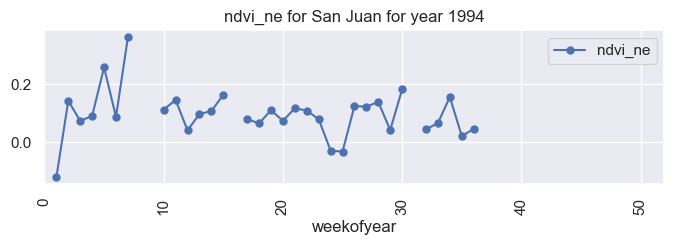

In [33]:
sns.set(rc={'figure.figsize':(8,2)})
df_train_features_sj.loc[(df_train_features_sj['year']==1994),][['weekofyear','ndvi_ne']].plot(x='weekofyear',y='ndvi_ne',rot=90,marker = '.', markersize = 10)
plt.xlim((0,52))
plt.title('ndvi_ne for San Juan for year 1994')

#### Year on year plot for station_avg_temp_c for Iquitos

station_avg_temp_c has 7% missing values for IQ so we will look at that. From the graph we see that year 2008 is the most problematic from 23rd to 30th week

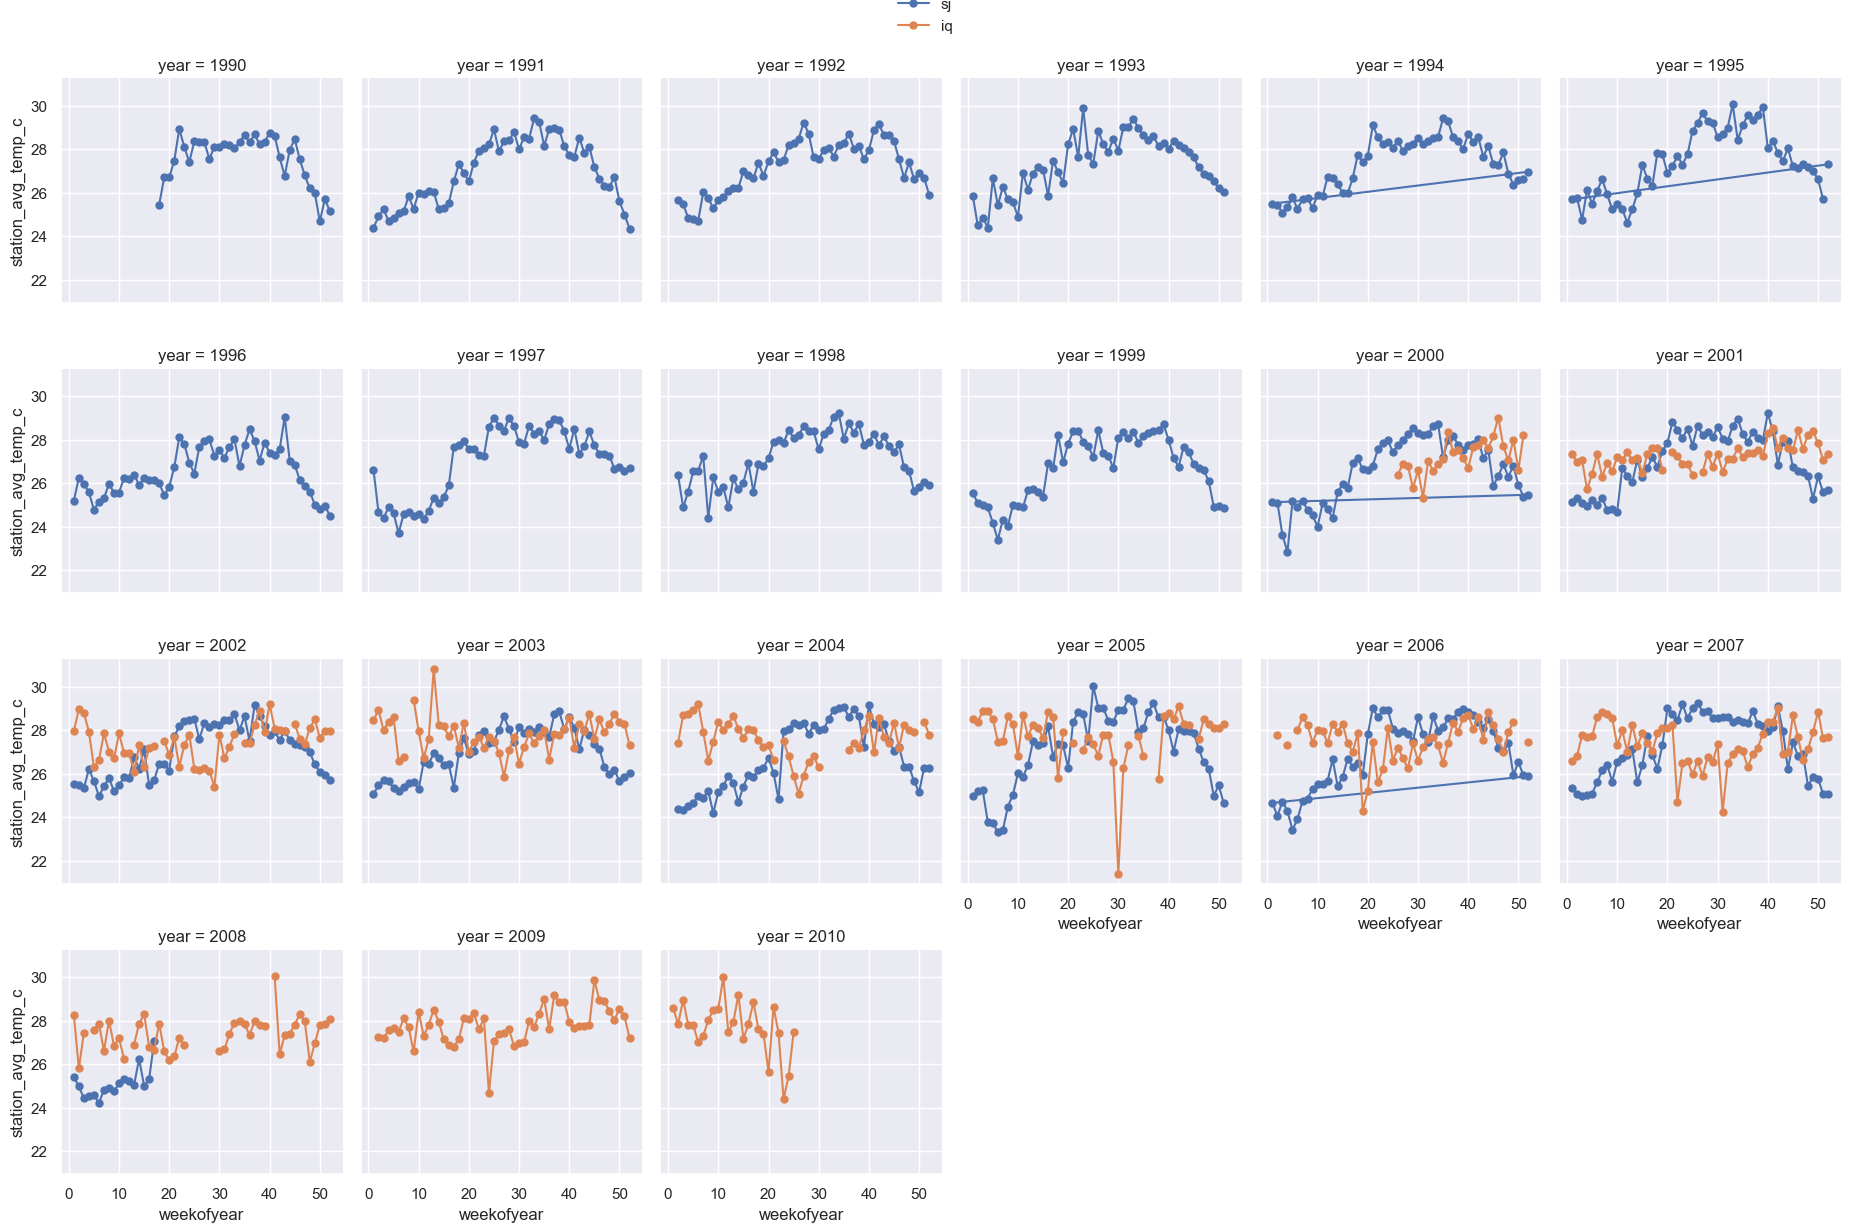

In [34]:
sns.set(rc={'figure.figsize':(20,35)})
graph = sns.FacetGrid(df_train_features,col='year', hue='city', col_wrap=6)
graph.map_dataframe(plt.plot,'weekofyear','station_avg_temp_c', marker = '.', markersize = 10).add_legend(loc='upper center',borderaxespad=-2)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'station_avg_temp_c for Iquitos for year 2008')

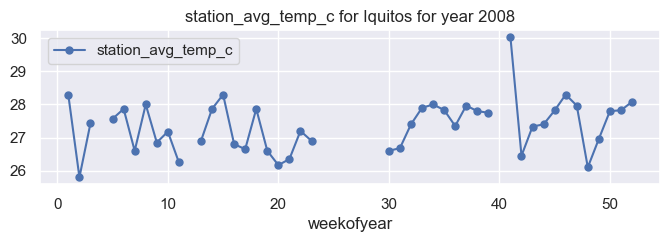

In [35]:
sns.set(rc={'figure.figsize':(8,2)})
df_train_features_iq.loc[(df_train_features_iq['year']==2008),][['weekofyear','station_avg_temp_c']].plot(x='weekofyear',y='station_avg_temp_c',marker = '.', markersize = 10)
plt.title('station_avg_temp_c for Iquitos for year 2008')

### Filling in Missing Values

Filling in all values with more than 1% missing values with ARIMA forecaster. Otherwise forward fill is used 

In [36]:
for i in range(len(useable_features)):
    if (df_missing_stats.reset_index().loc[df_missing_stats.reset_index()['index']==useable_features[i],'precent_missing_sj'].values[0] > 1):
        print(useable_features[i])
        result = adfuller(df_train_features_sj.loc[:,useable_features[i]].dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

ndvi_ne
ADF Statistic: -5.125328
p-value: 0.000012
ndvi_nw
ADF Statistic: -2.892267
p-value: 0.046255
ndvi_se
ADF Statistic: -9.594164
p-value: 0.000000
ndvi_sw
ADF Statistic: -9.865577
p-value: 0.000000


In [37]:
for i in range(len(useable_features)):
    if (df_missing_stats.reset_index().loc[df_missing_stats.reset_index()['index']==useable_features[i],'precent_missing_iq'].values[0] > 1):
        print(useable_features[i])
        result = adfuller(df_train_features_iq.loc[:,useable_features[i]].dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

station_avg_temp_c
ADF Statistic: -6.072770
p-value: 0.000000
station_diur_temp_rng_c
ADF Statistic: -6.140134
p-value: 0.000000
station_max_temp_c
ADF Statistic: -7.501546
p-value: 0.000000
station_min_temp_c
ADF Statistic: -5.387557
p-value: 0.000004
station_precip_mm
ADF Statistic: -5.981924
p-value: 0.000000


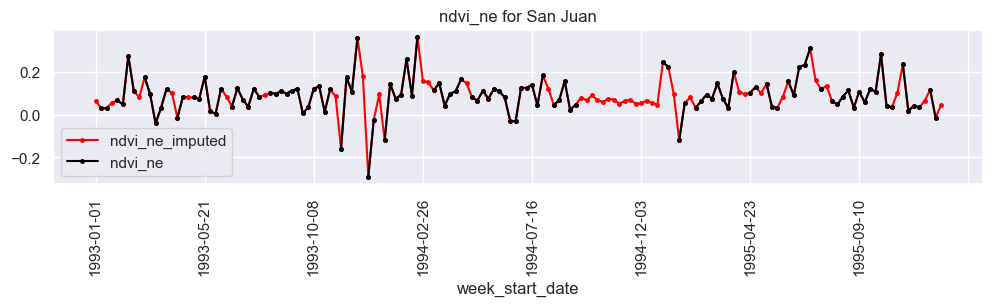

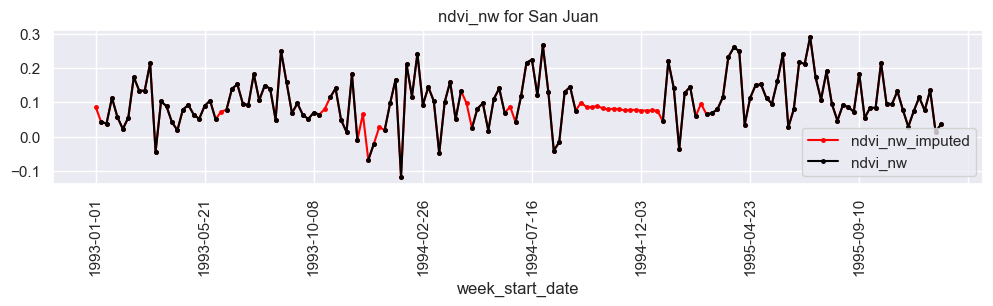

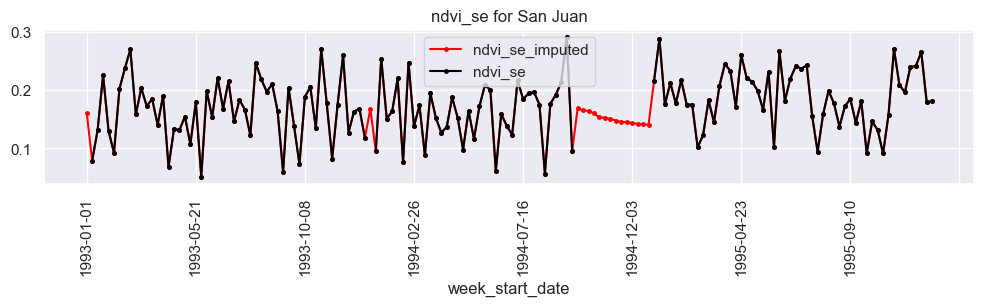

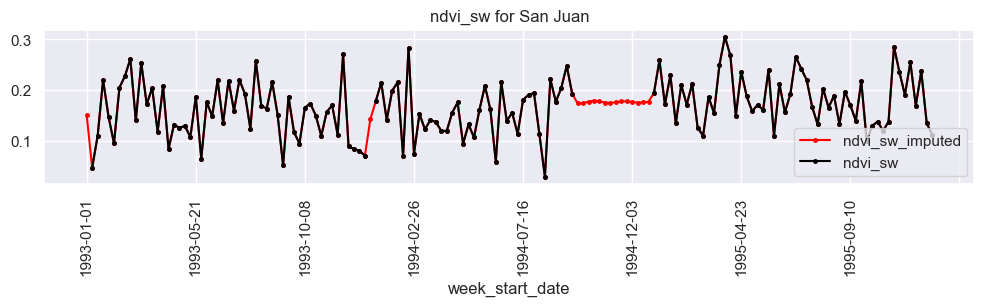

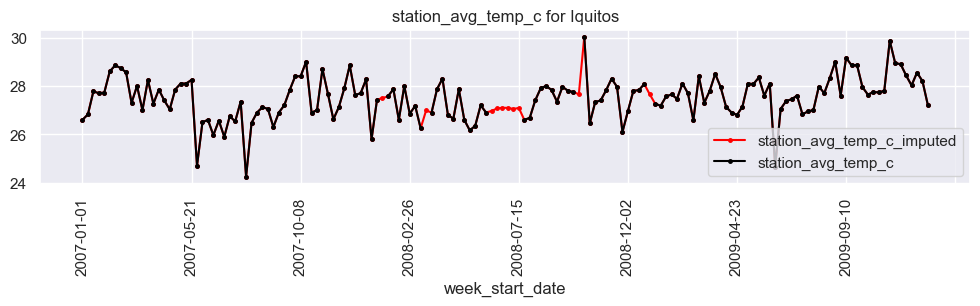

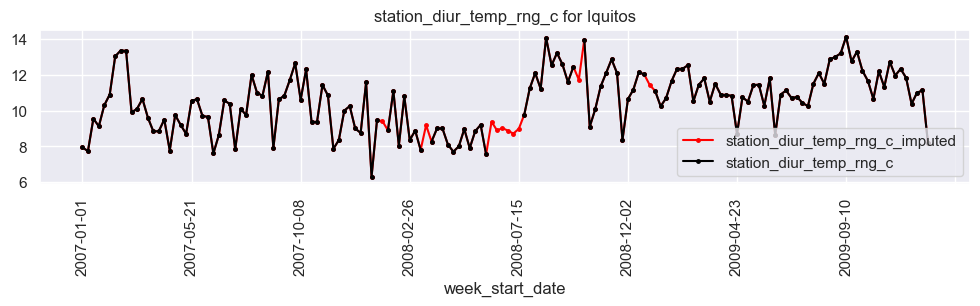

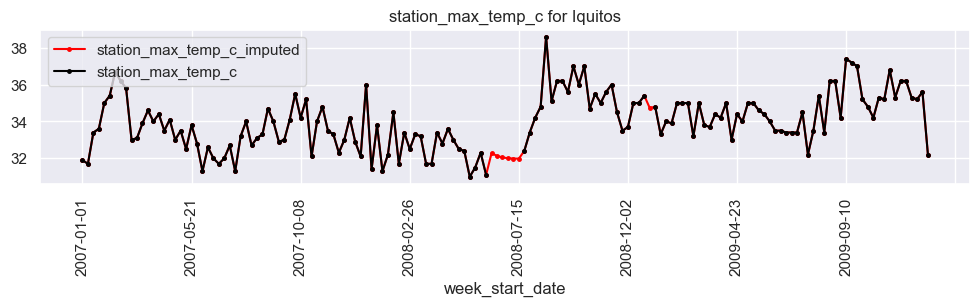

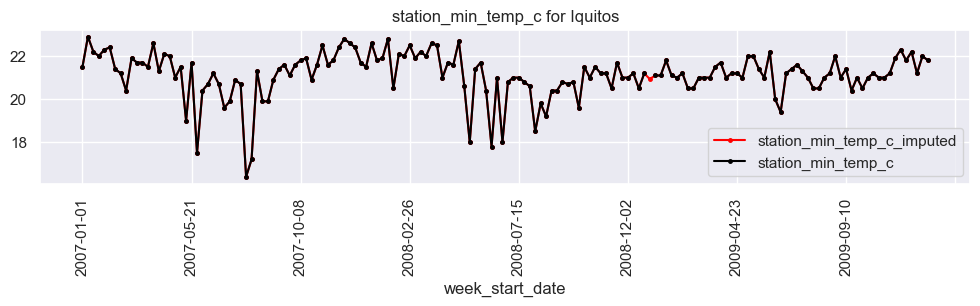

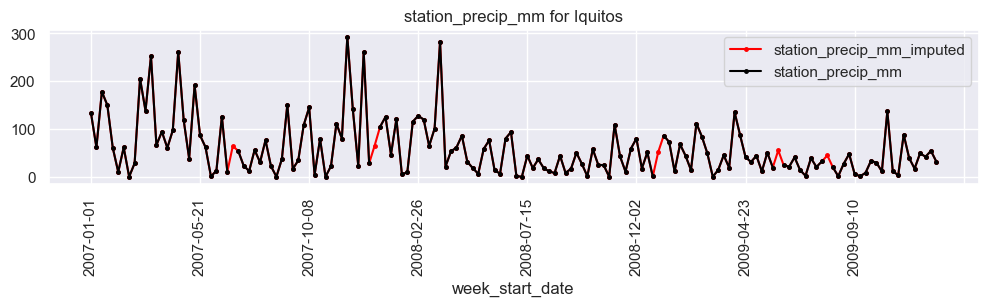

In [38]:
missing_threshold = 1
forecaster= ARIMA((4,0,4), suppress_warnings=True)

def impute(df,colname, plot_graphs=True):
    for i in range(len(df.columns)):
        #SELECTING VARIABLE TO IMPUTE
        var = df_missing_stats.reset_index().iloc[i,0]
        
        #IF IT'S MISSING PERCENTAGE IS > MISSING THRESHOLD THEN USE FORECASTER
        if (df_missing_stats.reset_index().loc[i,colname] > missing_threshold):
            transformer = Imputer(method="forecaster",forecaster=forecaster) #ARIMA FORECASTER
            df.loc[:,var+'_imputed'] = transformer.fit_transform(df.loc[:,var])
            
            
            #PLOTTING VEGETATION FIELDS FOR SAN JUAN
            if plot_graphs:
                if 'ndvi' in var and 'sj' in colname :
                    fig, ax = plt.subplots(figsize=(12,2));
                    plt.title(var+' for San Juan')
                    df.loc[((df['year']>=1993)&(df['year']<=1995)),][['week_start_date',var+'_imputed']].plot(ax=ax,x='week_start_date',y=var+'_imputed',marker = '.', markersize = 5,color='red',rot=90)
                    df.loc[((df['year']>=1993)&(df['year']<=1995)),][['week_start_date',var]].plot(ax=ax,x='week_start_date',y=var,marker = '.', markersize = 5,color='black', rot=90)

                #PLOTTING STATION FIELDS FOR IQUITOS
                if 'station' in var and 'iq' in colname :
                    fig, ax = plt.subplots(figsize=(12,2));
                    plt.title(var+' for Iquitos')
                    df.loc[((df['year']>=2007)&(df['year']<=2009)),][['week_start_date',var+'_imputed']].plot(ax=ax,x='week_start_date',y=var+'_imputed',marker = '.', markersize = 5,color='red',rot=90)
                    df.loc[((df['year']>=2007)&(df['year']<=2009)),][['week_start_date',var]].plot(ax=ax,x='week_start_date',y=var,marker = '.', markersize = 5,color='black', rot=90)
            df.drop(var, axis=1,inplace=True)
            df.loc[:,var] = df.loc[:,var+'_imputed']
            df.drop(var+'_imputed', axis=1,inplace=True)
        #IF MISSING % IS LESS THAN MISSING THRESHOLD THEN USE FORWARD FILL
        elif (df_missing_stats.reset_index().loc[i,colname] > 0) :
            df.loc[:,var] = df[var].fillna(method="ffill")
    return df


df_train_features_sj_imputed = impute(df_train_features_sj.copy(),'precent_missing_sj')
df_train_features_iq_imputed = impute(df_train_features_iq.copy(),'precent_missing_iq')
df_train_features_imputed = pd.concat([df_train_features_sj_imputed,df_train_features_iq_imputed])

### Train Test Split preparation

In [40]:
def hold_out_set(df_features,df_labels,label_col,split):
    all_features = df_features.columns
    train_size = int(len(df_features) * split)
    test_size = len(df_features) - train_size
    X_train, X_test = df_features.loc[0:train_size,all_features], df_features.loc[train_size:len(df_features),all_features]
    y_train, y_test = df_labels.loc[0:train_size,label_col], df_labels.loc[train_size:len(df_labels),label_col]
    #print('Train data: ', X_train.shape)
    #print('Test data: ', X_test.shape)
    
    return X_train, X_test, y_train, y_test

### Feature Importance from Random Forest (Using current week's data to predict number of cases)

Mean Absolute Error: 8
Mean Absolute Error: 34


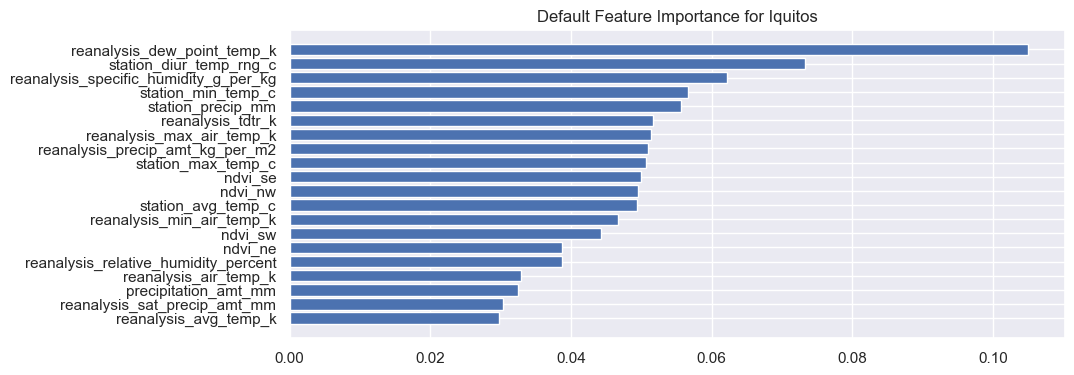

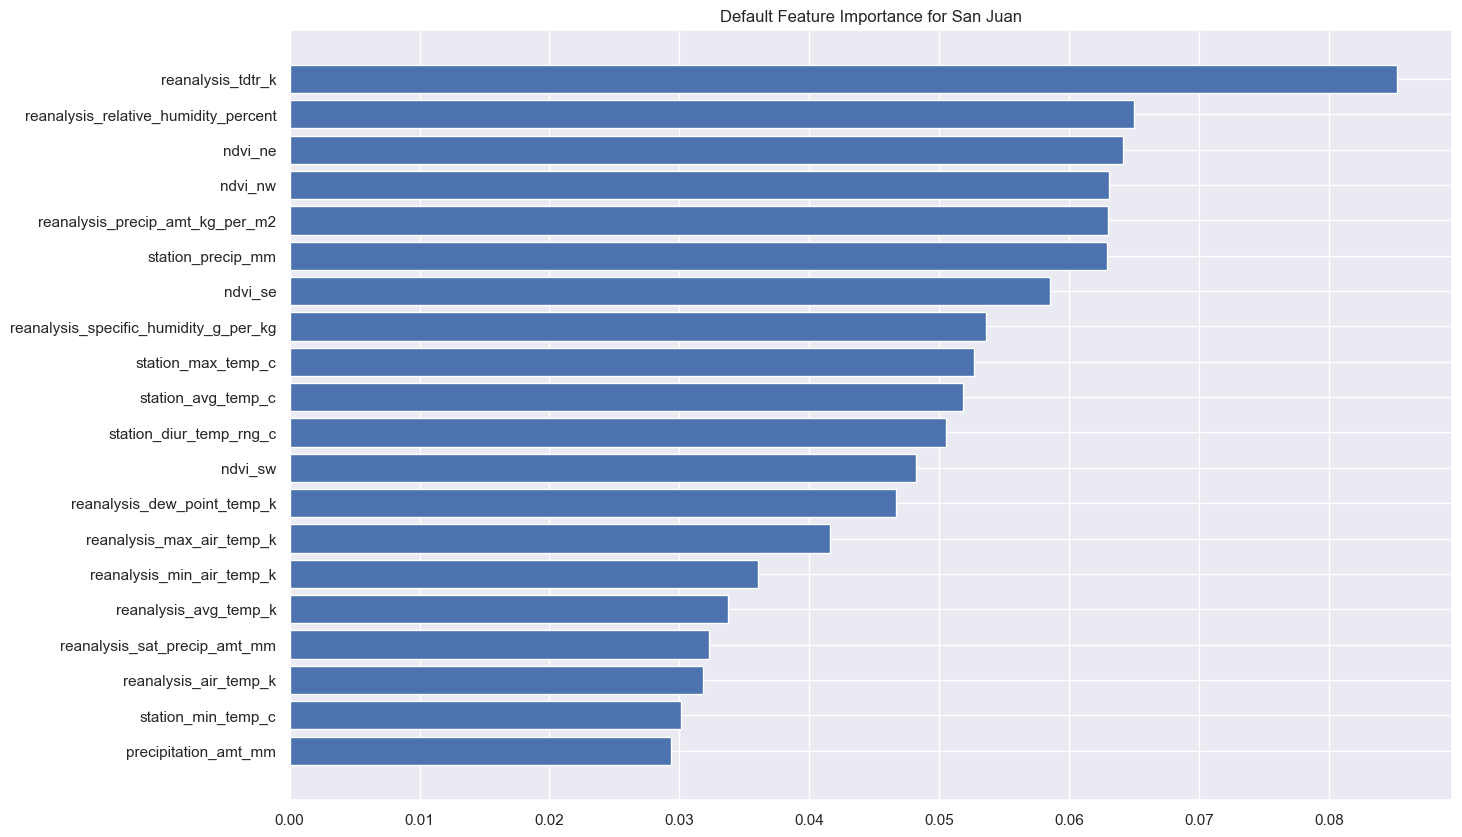

In [41]:
def feature_importance(df_train,df_labels,label_col,ttl,split):
    X_train, X_test, y_train, y_test = hold_out_set(df_train,df_labels,label_col,split)
    rf= RandomForestRegressor(n_estimators=100,criterion='absolute_error')
    split = TimeSeriesSplit(n_splits=5)
    score= cross_val_score(rf, X_train,y_train, cv=split, 
                           scoring='neg_mean_absolute_error')
    rf.fit(X_train, y_train)
    sorted_idx = rf.feature_importances_.argsort()
    all_features = X_train.columns
    g = plt.barh(all_features[sorted_idx], rf.feature_importances_[sorted_idx])
    plt.title('Default Feature Importance for '+ttl)
    
    #perm_importance = permutation_importance(rf, X_test, y_test)
    #sorted_idx = perm_importance.importances_mean.argsort()
    #g = plt.barh(all_features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    #plt.xlabel("Permutation Importance")
    top_10_features = list(all_features[sorted_idx][-10:])

    predictions = rf.predict(X_test)
    errors = abs(predictions - y_test)
    print('Mean Absolute Error:', math.floor(np.mean(errors)))
    return rf,g,top_10_features


plt.figure(figsize=(10,4))
rf_iq_static, g, top_10_features_iq_static = feature_importance(df_train_features_iq_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),  
                                           df_train_labels_iq,'total_cases',
                                           'Iquitos',0.70)
plt.figure(figsize=(15,10))
rf_sj_static,g,top_10_features_sj_static = feature_importance(df_train_features_sj_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1), 
                                          df_train_labels_sj,'total_cases',
                                          'San Juan',0.70)


### Cross validation using different models

In [42]:
def pipeline_cross_val(df_features, df_labels,col,label='total_cases',split=0.70):
    X_train, X_test, y_train, y_test = hold_out_set(df_features,df_labels,label,split)

    split = TimeSeriesSplit(n_splits=5)
    models = { 'Linear Regression': linear_model.LinearRegression(),
             'RF': RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=4),
             'SVR': make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.5)),
             'Poisson Regressor': linear_model.PoissonRegressor(warm_start=True),
             'Bayesian Ridge': linear_model.BayesianRidge(),
             'Lasso': linear_model.LassoLars(alpha=.1, normalize=False)}
    train_scores = {}
    test_scores = {}

    best_score = -999999
    for key, value in models.items():
        score= cross_val_score(value, X_train,y_train, cv=split, 
                               scoring='neg_mean_absolute_error')
        value.fit(X_train, y_train)
        train_scores[key] = abs(score[-1])
        y_pred = value.predict(X_test)
        test_scores[key] = mae(y_test, y_pred)

    return pd.DataFrame.from_dict(train_scores, orient = 'index',columns=[col[0]]).join(pd.DataFrame.from_dict(test_scores, orient = 'index',columns=[col[1]]))  

### Prediction for San Juan using static data

San Juan:
Forward Filled Data:
Data imputed with ARIMA:
Only top 10 features used:


,trainScore_FFill,testScore_FFill,trainScore_ARIMA,testScore_ARIMA,trainScore_top10features,testScore_top10features
Linear Regression,33.745345,33.280636,32.529793,29.196670,32.047947,28.034995
RF,23.345688,21.751851,22.271239,21.077918,20.431284,20.786904
SVR,17.755999,18.368043,17.746326,18.329979,17.014737,18.724639
Poisson Regressor,31.539867,25.182110,29.810168,25.636850,28.981606,26.089353
Bayesian Ridge,28.014379,26.661617,28.005751,26.661054,27.261498,25.814289
Lasso,30.171983,27.034731,29.821567,27.251378,31.579715,27.085891


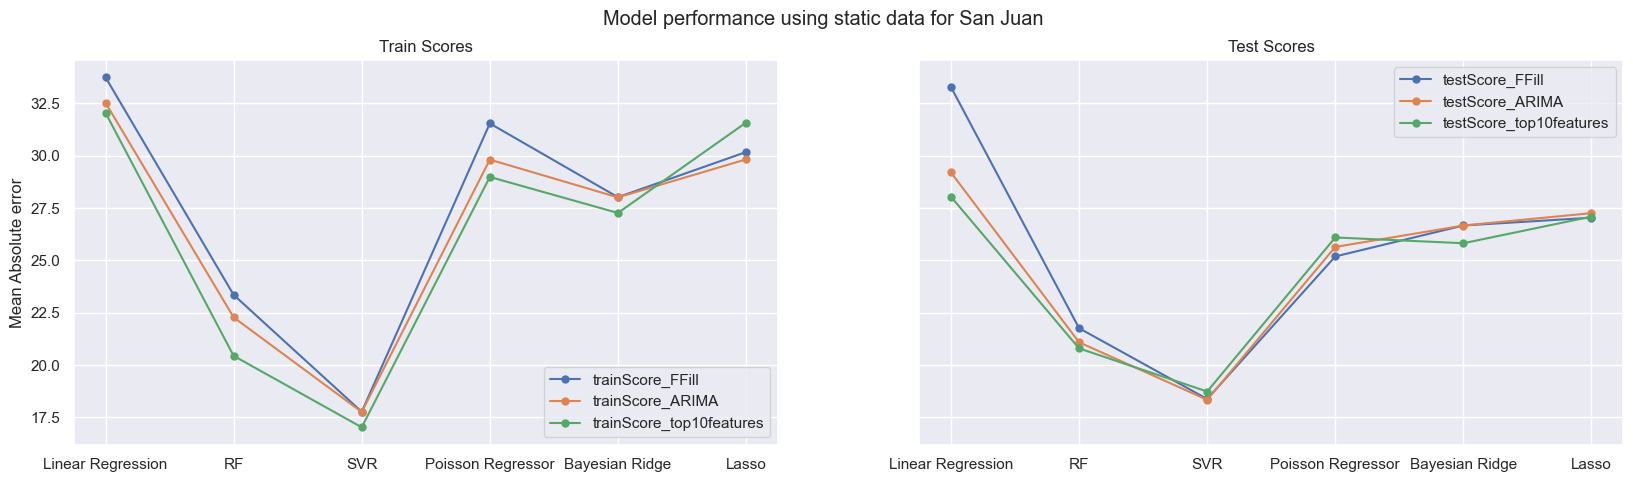

In [43]:
print('San Juan:')
print('Forward Filled Data:')
df_ffill = pipeline_cross_val(df_train_features_sj.fillna(method="ffill").drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_sj,['trainScore_FFill','testScore_FFill'])

print('Data imputed with ARIMA:')
df_arima = pipeline_cross_val(df_train_features_sj_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_sj,['trainScore_ARIMA','testScore_ARIMA'])


print('Only top 10 features used:')
df_top10 = pipeline_cross_val(df_train_features_sj_imputed[top_10_features_sj_static],
                   df_train_labels_sj,['trainScore_top10features','testScore_top10features'])
display(pd.concat([df_ffill,df_arima,df_top10],axis=1))

fig, axs = plt.subplots(1,2,sharey=True, sharex=True)
df = pd.concat([df_ffill,df_arima,df_top10],axis=1)
df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for San Juan');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Prediction for Iquitos using static data

Iquitos:
Forward Filled Data:
Data imputed with ARIMA:
Only top 10 features used:


,trainScore_FFill,testScore_FFill,trainScore_ARIMA,testScore_ARIMA,trainScore_top10features,testScore_top10features
Linear Regression,4.004173,7.438405,3.984435,7.429026,3.886353,7.299477
RF,3.512667,7.840449,3.173667,7.778526,3.178917,7.824199
SVR,2.715252,7.488533,2.731422,7.461290,2.956767,7.517452
Poisson Regressor,3.880183,7.459662,3.834298,7.473319,3.986076,7.388136
Bayesian Ridge,3.725062,7.619573,3.727294,7.626264,3.784596,7.484652
Lasso,3.945884,7.516061,3.792386,7.510525,4.119775,7.483879


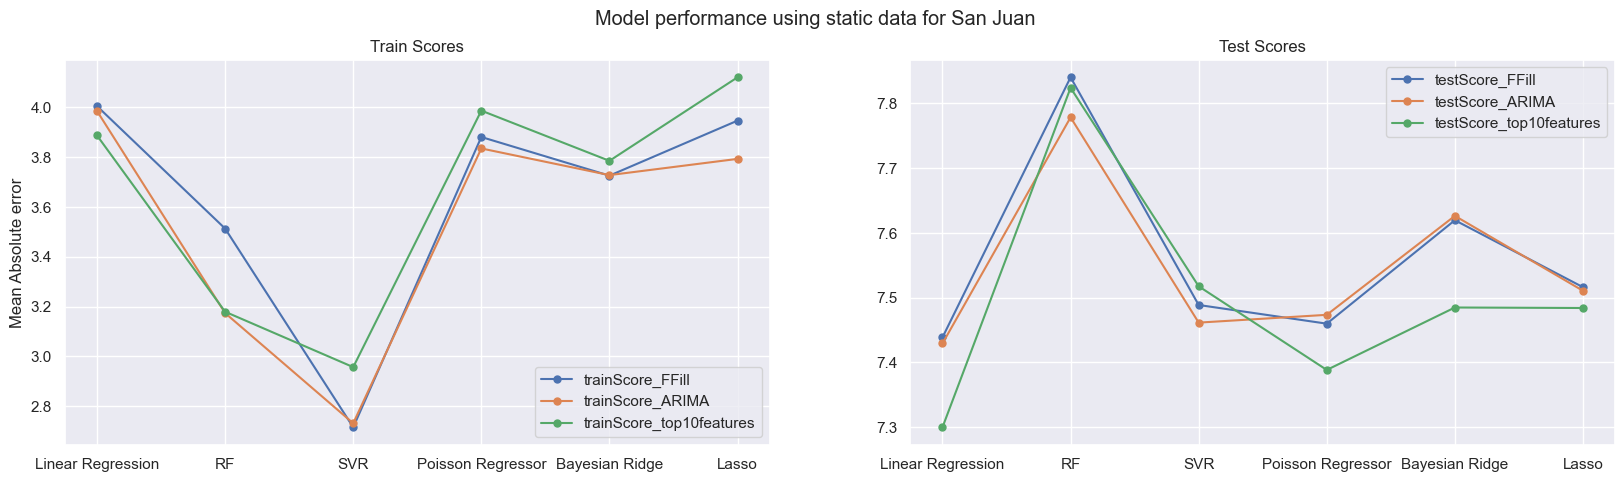

In [44]:
print('Iquitos:')
print('Forward Filled Data:')
df_ffill = pipeline_cross_val(df_train_features_iq.fillna(method="ffill").drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_iq,['trainScore_FFill','testScore_FFill'])

print('Data imputed with ARIMA:')
df_arima = pipeline_cross_val(df_train_features_iq_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_iq,['trainScore_ARIMA','testScore_ARIMA'])


print('Only top 10 features used:')
df_top10 = pipeline_cross_val(df_train_features_iq_imputed[top_10_features_iq_static],
                   df_train_labels_iq,['trainScore_top10features','testScore_top10features'])
display(pd.concat([df_ffill,df_arima,df_top10],axis=1))

fig, axs = plt.subplots(1,2, sharex=True)
df = pd.concat([df_ffill,df_arima,df_top10],axis=1)
df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for San Juan');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');